# Dynamic Linear Model

In [60]:
import os
import math

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam
from pyro.ops.stats import quantile
from pyro.ops.indexing import Vindex

from main import get_energy_data, get_weather_data
import pandas as pd
import matplotlib.pyplot as plt

pyro.set_rng_seed(20200928)
torch.manual_seed(20200101)

pd.set_option('display.max_rows', 500)



## Data

In [6]:
# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("D") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)

# convert to torch tensors
X_W = torch.from_numpy(dfW.values).float()
X_E = torch.from_numpy(dfE.values).float()
obs = torch.from_numpy(df["price actual"].values).float()


# translate to pyro forecasting language
T = None # number of time steps to include, if None all data is used
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]
# covariates = X_E if T is None else X_E[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting

# start, train end, test end
T0 = 0
T1 = n - n//10 # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

Number of observations: 1461
Number of training observations: 1315
Number of test observations: 146


## Model

In [69]:
class VanillaDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


        self.tau = 1
        self.M = 4

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        covariates = x_E

        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)        

        season_plate = pyro.plate("season", self.M, dim=-2)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        
        with season_plate:
            with self.time_plate:
                with poutine.reparam(config={"drift": LocScaleReparam()}):
                    drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))

        # with self.time_plate:
        # z = pyro.sample("z_0", dist.Categorical(torch.ones(self.M) / self.M), infer={"enumerate": "parallel"})

        # weight 
        for t in pyro.markov(range(duration)):
            z[t] = pyro.sample(f"z_{t+1}", dist.Categorical(torch.ones(self.M) / self.M), infer={"enumerate": "parallel"})
            # weight[t] 


        print(z.shape, drift.shape)
        # print(drift.shape)

        # weight = drift.cumsum(-2)[z]  # A Brownian motion.
        weight = Vindex(drift.cumsum(-2))[z]
        print("weight", weight.shape)
        # record in model_trace
        pyro.deterministic("weight", weight)

        prediction = (weight * covariates).sum(-1, keepdim=True)
        print("prediction", prediction.shape)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        # add noise
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)
        # noise_dist = dist.Normal(torch.zeros((duration)), torch.ones((duration))*sigma).to_event(0)
        # print(noise_dist.event_shape)

        # scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        # noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)

pyro.set_rng_seed(1)
pyro.clear_param_store()
model = VanillaDLM()
guide = AutoNormal(poutine.block(model, hide=[f"z_{i}" for i in range(T1+1)]))
# optim = Adam({ 'lr': 1e-3 })
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=10,
    guide = guide,
    # optim = optim,
)

with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

NameError: name 'z' is not defined

## Inference

In [7]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = VanillaDLM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

INFO 	 step    0 loss = 2.98122e+14
INFO 	 step  100 loss = 129.652
INFO 	 step  200 loss = 7.62928
INFO 	 step  300 loss = 5.58352
INFO 	 step  400 loss = 5.21476
INFO 	 step  500 loss = 5.20428
INFO 	 step  600 loss = 4.63321
INFO 	 step  700 loss = 5.84148
INFO 	 step  800 loss = 4.73587
INFO 	 step  900 loss = 4.70049


CPU times: total: 1min 3s
Wall time: 10.6 s


In [62]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

# posterior_samples["prediction"].shape


weight torch.Size([100, 1, 1, 4, 1461, 10])
prediction torch.Size([100, 1, 1, 4, 1461, 1])


## Analyze posterior samples

In [15]:
posterior_samples.keys()

dict_keys(['particles', 'time', 'drift_scale', 'drift_decentered', 'drift', 'weight', 'prediction', 'noise_scale', 'residual'])

In [57]:
# extract percentiles of the posterior samples
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)

ValueError: x and y must have same first dimension, but have shapes (1315,) and torch.Size([1, 1, 4, 1461])

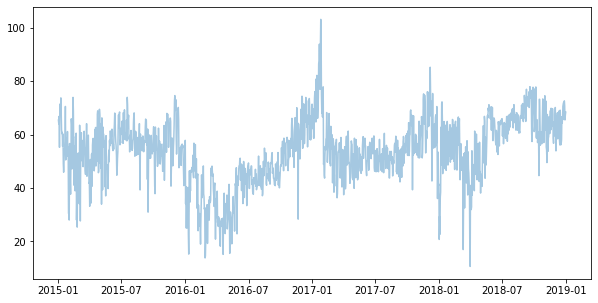

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

Mean price:  tensor(53.7429)
Mean abs residual:  tensor(12.9040)
Mean abs train residual:  tensor(12.5122)
Mean abs residual:  tensor(16.4330)


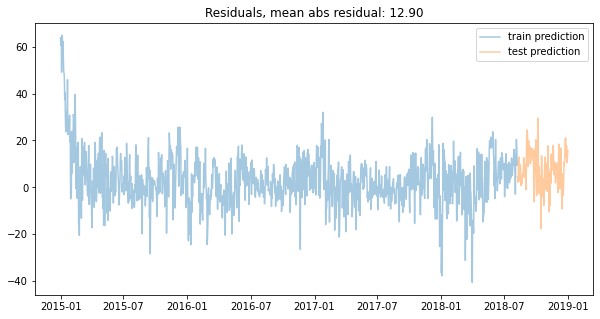

In [14]:
resid = obs - posterior_samples['prediction'].squeeze()

resid_p10, resid_p50, resid_p90 = quantile(resid, (0.1, 0.5, 0.9)).squeeze(-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], resid_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], resid_p50[T1:], label="test prediction", alpha = .4)
# ax.fill_between(dates, resid_p10, resid_p90, color="red", alpha=0.3)
ax.legend()
ax.set_title("Residuals, mean abs residual: {:.2f}".format(resid.abs().mean()))

print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs residual: ", resid[:, T1:].abs().mean())

In [23]:
# resid[T1:]
resid.shape

torch.Size([100, 178181])